In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from torch.utils.data import DataLoader

from models.MeTooDataset import MeTooDataset

In [2]:
experiment_name = '12A'

In [3]:
stopwords_en = stopwords.words('english')
stopwords_en.extend(['quote', 'answer', 'retweet', 'full', 'text']) # Additional stopwords due to Twitter API and annotation process

In [4]:
tokenizer = TweetTokenizer()

In [5]:
labels = {'Against', 'Neutral', 'Favor'}

In [6]:
labels_mapper = {
    0: 'Against',
    1: 'Neutral',
    2: 'Favor'
}

In [7]:
profile_ids = [783214, 19568591, 103018203, 256881576, 810619093749559296]

In [8]:
users = list('ABDEF')

# Setup

In [9]:
dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='bag_of_words',
    task='metoo_training'
)

In [10]:
dataloader = DataLoader(dataset)

# Preparing Vocabularies

In [11]:
label_vocabularies = {
    'Against':  set(
        word
        for _, (tweet, stance) in enumerate(dataloader, 1)
        for word in tokenizer.tokenize(tweet[0])
        if stance == 0
    ),
    'Neutral':  set(
        word
        for _, (tweet, stance) in enumerate(dataloader, 1)
        for word in tokenizer.tokenize(tweet[0])
        if stance == 1
    ),
    'Favor':  set(
        word
        for _, (tweet, stance) in enumerate(dataloader, 1)
        for word in tokenizer.tokenize(tweet[0])
        if stance == 2
    ),
}

# Computing Unique Vocabularies

In [12]:
unique_label_vocabularies = {
    label: label_vocabularies[label] - {word for other_label in (labels - {label}) for word in label_vocabularies[other_label]}
    for label in labels
}

# Determine Top 10 Unique Words per Stance

In [13]:
unique_words_count = {
    label: Counter(
        word
        for _, (tweet, stance) in enumerate(dataloader)
        for word in tokenizer.tokenize(tweet[0])
        if labels_mapper[int(stance)] == label and word in unique_label_vocabularies[label]
    )
    for label in labels
}

In [14]:
unique_words_df = pd.DataFrame.from_dict(
    {
        label: [
            (word, count)
            for word, count in unique_words_count[label].most_common(10)
        ]
        for label in labels
    }
)

unique_words_df = unique_words_df[['Against', 'Neutral', 'Favor']]

In [15]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_training.tex', 'w') as f:
    unique_words_df.to_latex(f)

# Prepare DataFrame

In [16]:
df = pd.DataFrame.from_dict(
    {
        label: {
            'Number of Unique Words': len(unique_label_vocabularies[label])
        }
        for label in labels
    },
    orient='columns'
)

df = df[['Against', 'Neutral', 'Favor']]

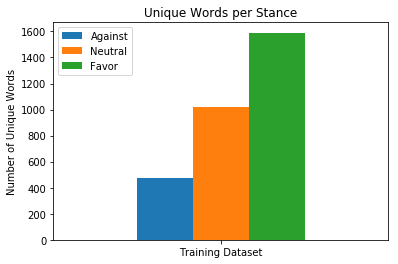

In [17]:
df.plot(kind='bar', title='Unique Words per Stance', rot=0)

plt.ylabel('Number of Unique Words')
plt.xticks(np.arange(1), ['Training Dataset'])
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_training.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Setup

In [18]:
dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='bag_of_words',
    task='metoo_testing'
)

In [19]:
dataloader = DataLoader(dataset)

# Preparing Vocabularies

In [20]:
vocabularies = {
    user_id: {
        word
        for _, (tweet, _, idx) in enumerate(dataloader)
        for word in tokenizer.tokenize(tweet[0])
        if idx == user_id
    }
    for user_id in profile_ids
}

In [21]:
intersection_vocabulary_lengths = {
    user_id: {
        label: len(vocabularies[user_id].intersection(unique_label_vocabularies[label]))
        for label in labels
    }
    for user_id in profile_ids
}

In [22]:
df = pd.DataFrame.from_dict(
    intersection_vocabulary_lengths, 
    orient='index'
)

df = df[['Against', 'Neutral', 'Favor']]

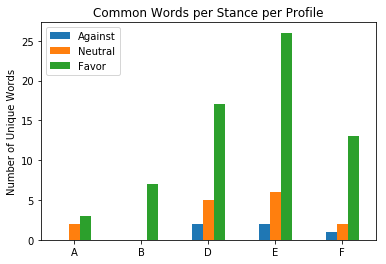

In [23]:
df.plot(kind='bar', title='Common Words per Stance per Profile', rot=0)

plt.ylabel('Number of Unique Words')
plt.xticks(np.arange(len(users)), users)
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_testing.eps', 'wb') as f:
    plt.savefig(f, format='eps')

# Determine Top 10 Words per Profile

In [24]:
vocabularies_counters = {
    user_id: Counter(
        word
        for _, (tweet, _, idx) in enumerate(dataloader)
        for word in tokenizer.tokenize(tweet[0])
        if idx == user_id and not word in stopwords_en and not word in string.punctuation
    )
    for user_id in profile_ids
}

In [25]:
vocabularies_df = pd.DataFrame.from_dict(
    {
        user_id: [
            (word, count)
            for word, count in vocabularies_counters[user_id].most_common(10)
        ]
        for user_id in profile_ids
    }
)

In [26]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_profiles.tex', 'w') as f:
    vocabularies_df.to_latex(f)